In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV

from kaggle_prediction_interval_birthweight.model.sampling_utils import (
    compute_highest_density_interval,
)
from kaggle_prediction_interval_birthweight.workflow.metric import score
from kaggle_prediction_interval_birthweight.data.data_processing import DataProcessor
from kaggle_prediction_interval_birthweight.model.linear_regression import (
    RidgeRegressor,
)
from kaggle_prediction_interval_birthweight.model.hist_gradient_boosting import (
    HistBoostRegressor,
)
from kaggle_prediction_interval_birthweight.model.neural_network import (
    BayesianNeuralNet,
)
from kaggle_prediction_interval_birthweight.model.ensembler import (
    Ensembler,
)

In [3]:
data = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

In [4]:
train_processor = DataProcessor(model_type="linear regression")
X, y = train_processor(data)

test_processor = DataProcessor(
    model_type="linear regression",
    feature_categories=train_processor.feature_categories,
    standardization_parameters=train_processor.standardization_parameters,
)
X_test = test_processor(data_test)

In [5]:
ridge_regressor = RidgeRegressor().fit(X, y)

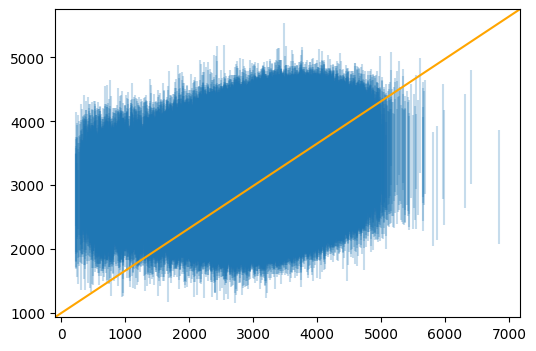

In [6]:
lower_ridge, upper_ridge = ridge_regressor.predict_intervals(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.vlines(x=data["DBWT"], ymin=lower_ridge, ymax=upper_ridge, alpha=0.25)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="orange")
plt.show()

In [137]:
train_processor = DataProcessor(model_type="neural network")
X, y = train_processor(data)

bayesian_net = BayesianNeuralNet(
    n_units=200, n_layers=1, l2_penalty=1e-6, batch_size=1000, verbose=1, n_epochs=100
)
bayesian_net.fit(X, y)

Epoch 1/100
109/109 [==============================] - 3s 20ms/step - loss: 1.4690
Epoch 2/100
109/109 [==============================] - 2s 21ms/step - loss: 1.4226
Epoch 3/100
109/109 [==============================] - 2s 20ms/step - loss: 1.4057
Epoch 4/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3926
Epoch 5/100
109/109 [==============================] - 2s 20ms/step - loss: 1.3839
Epoch 6/100
109/109 [==============================] - 2s 21ms/step - loss: 1.3783
Epoch 7/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3734
Epoch 8/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3697
Epoch 9/100
109/109 [==============================] - 3s 23ms/step - loss: 1.3656
Epoch 10/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3619
Epoch 11/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3587
Epoch 12/100
109/109 [==============================] - 2s 22ms/step - loss: 1.3559
E

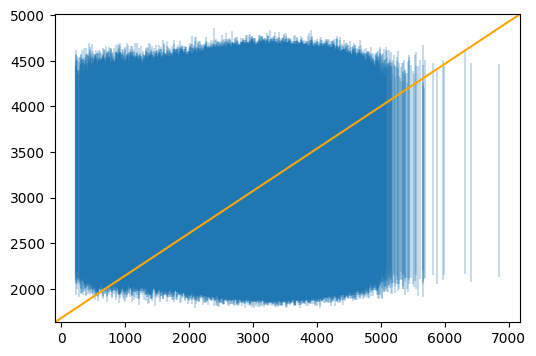

In [138]:
lower_nn, upper_nn = bayesian_net.predict_intervals(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.vlines(x=data["DBWT"], ymin=lower_nn, ymax=upper_nn, alpha=0.25)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="orange")
plt.show()

In [ ]:
train_processor = DataProcessor(model_type="xgboost")
X, y = train_processor(data)

histboost_regressor = HistBoostRegressor()
histboost_regressor.fit(X, y)

lower_histboost, upper_histboost = histboost_regressor.predict_intervals(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.vlines(x=data["DBWT"], ymin=lower_histboost, ymax=upper_histboost, alpha=0.25)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="orange")
plt.show()

In [ ]:
ensembler = Ensembler()
ensembler.fit(data)

In [ ]:
lower_ensemble, upper_ensemble = ensembler.predict_intervals(data)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.vlines(x=data["DBWT"], ymin=lower_ensemble, ymax=upper_ensemble, alpha=0.25)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="orange")
plt.show()

In [ ]:
lower, upper = compute_highest_density_interval(data["DBWT"])

print(f"Coverage is {data['DBWT'].between(lower, upper).mean() * 100:.1f}%")

data["DBWT"].hist(bins=100)
plt.axvline(lower, color="orange")
plt.axvline(upper, color="orange")
plt.show()

In [ ]:
nois, coverage = score(data["DBWT"].values, lower, upper, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")

In [ ]:
nois, coverage = score(data["DBWT"].values, lower_ridge, upper_ridge, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")

In [ ]:
nois, coverage = score(data["DBWT"].values, lower_histboost, upper_histboost, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")

In [59]:
nois, coverage = score(data["DBWT"].values, lower_nn, upper_nn, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")

NOIS is 2438.1, and coverage is 95.3%


In [ ]:
nois, coverage = score(data["DBWT"].values, lower_ensemble, upper_ensemble, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")